# Importations

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
import gc ,random 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
from sklearn import model_selection

import cv2
import SimpleITK as sitk
from ipywidgets import interact, fixed
from tqdm import tqdm 
import matplotlib.pyplot as plt
from PIL import Image

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from transformers import get_linear_schedule_with_warmup
import albumentations as A 

from collections import OrderedDict
from sklearn.model_selection import train_test_split

from loss.dice import * 
from loss.ssim import * 
from models.UNet import *
from datasets.merging_dataset import * 

In [3]:
# SEED Everything 
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Loss Function 

In [4]:
def dice(pred, target, smooth = 1.):
    pred = torch.sigmoid(pred)
    pred = pred.contiguous()
    target = target.contiguous()    

    intersection = (pred * target).sum(dim=2).sum(dim=2)
    
    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))
    loss_label_1 = loss[:,0].mean()
    loss_label_2 = loss[:,1].mean()
    loss_label_3 = loss[:,2].mean()
    loss_label_4 = loss[:,3].mean()

    return ((loss_label_1+loss_label_2+loss_label_3+loss_label_4)/4 , (loss_label_1 , loss_label_2 ,loss_label_3,loss_label_4))

# Engine 

In [5]:
def train_fn(data_loader, model, optimizer, scheduler,device):
    
    model.train()
   
    tr_loss = 0 
    counter = 0 
    if verbose :
        tk0 = tqdm(enumerate(data_loader), total=len(data_loader))
    else : 
        tk0 = enumerate(data_loader)
    for bi, d in tk0 : # LOOP : batch number i   
        

        y = d["label"].to(device, dtype=torch.long)

        x = d["LR"].to(device, dtype=torch.float) 
    
        y_hat   = model(x.unsqueeze(1)) #forward prop
        loss , _  = dice(y_hat, y) # Loss calaculation of batch i 
        optimizer.zero_grad() #
       
        tr_loss += loss.item()
        counter +=1 
        
        loss.backward()  # backward prop 
        optimizer.step() 
        
        
    return tr_loss/counter


In [6]:
def eval_fn(data_loader, model , device ):
    model.eval()
    tr_loss = 0
    counter = 0
    
    label1_loss  = 0
    label2_loss  = 0 
    label3_loss  = 0 
    label4_loss = 4 
    if verbose :
        tk0 = tqdm(enumerate(data_loader), total=len(data_loader))
    else : 
        tk0 = enumerate(data_loader)

    with torch.no_grad():
        
        for bi, d in tk0 :
       
            y = d["label"].to(device, dtype=torch.long)

            x = d["LR"].to(device, dtype=torch.float) 

            y_hat   = model(x.unsqueeze(1)) #forward prop
            
            loss , labels = dice(y_hat, y) # Loss calaculation of batch i 
            
            label1_loss += labels[0].item() 
            label2_loss += labels[1].item() 
            label3_loss += labels[2].item() 
            label4_loss += labels[3].item() 
            tr_loss += loss.item()
            counter +=1 

        
            
        return tr_loss/counter ,  (label1_loss /counter ,label2_loss /counter, label3_loss /counter,label4_loss/counter)

In [7]:
def run(model, EPOCHS , train_dataset , valid_dataset , device , LR , TRAIN_BATCH_SIZE ,VALID_BATCH_SIZE):
    
    train_data_loader = torch.utils.data.DataLoader(
        train_dataset,
        shuffle = True , 
        batch_size=TRAIN_BATCH_SIZE,
        num_workers=8
    )
    
    
    valid_data_loader = torch.utils.data.DataLoader(
        valid_dataset,
        batch_size=VALID_BATCH_SIZE,
        num_workers=4
    )

    num_train_steps = int(len(train_data_loader)) * EPOCHS
    optimizer = optim.Adam(model.parameters(), lr=LR)   
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=num_train_steps
    )
    train_loss =  []
    val_loss = []
    best_validation_dsc = 1.0
    patience = 0 
    print(f'Fold {f} ...')
    for epoch in range(EPOCHS):
        if verbose : 
            print(f'--------- Epoch {epoch} ---------')
        elif epoch%10==0 : 
            print(f'--------- Epoch {epoch} ---------')
        tr_loss=train_fn(train_data_loader, model, optimizer, scheduler,device)
        train_loss.append(tr_loss)
        
        if verbose : 
            print(f" train_loss  = {tr_loss}")
        elif epoch%10==0 : 
            print(f" train_loss  = {tr_loss}")
        

        
        val , _  = eval_fn(valid_data_loader, model,device)
        val_loss.append(val)
        if verbose : 
            print(f" val_loss  = {val}")
        elif epoch%10==0 : 
            print(f" val_loss  = {val}")
        

        
        if val < best_validation_dsc : 
            best_validation_dsc =val 
            patience = 0 
            torch.save(model.state_dict(), 'SUNet.pt')
        else : 
            patience +=1
        
        if patience>20 : 
            print(f'Eraly Stopping on Epoch {epoch}')
            print(f'Best Loss =  {best_validation_dsc}')
            break
        scheduler.step()
        
    model.load_state_dict(torch.load('SUNet.pt'), strict=False)
    return val_loss,train_loss

# Left hippocampal Model Training 

In [8]:
all_data = pd.read_csv('data_5fold.csv')
subjects = all_data[all_data['slice']==0]

In [9]:
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 16
LR = 7e-4
EPOCHS = 150
device = torch.device('cuda')
verbose = False 

In [ ]:
train_folds_loss = []
valid_folds_loss = []
for f in range(5) : 
    df_train = all_data[all_data['kfold'] !=f]
    df_valid = all_data[all_data['kfold'] ==f]
    Left_train_dataset = Merging_data_set(df_train ,  subjects  , Left = True , is_train = True)
    Left_valid_dataset = Merging_data_set(df_valid  ,  subjects  , Left = True , is_train  = False)
    Left_model = UNet(1,4)
    Left_model = Left_model.to(device)
    val_loss , train_loss =  run( Left_model  , EPOCHS , Left_train_dataset , Left_valid_dataset , device , LR , TRAIN_BATCH_SIZE , VALID_BATCH_SIZE )
    train_folds_loss.append(train_loss)
    valid_folds_loss.append(val_loss) 
    torch.save(Left_model.state_dict(), f'trained_model/UNet_segmentation/Unet Left fold {f}.pt')

[get_training_augmentation]  resize_to: (160, 160)
Fold 0 ...
--------- Epoch 0 ---------
 train_loss  = 0.7400944727659226
 val_loss  = 0.6962883806228638
--------- Epoch 10 ---------
 train_loss  = 0.10643369045108557
 val_loss  = 0.1288288240879774
--------- Epoch 20 ---------
 train_loss  = 0.10068037774413824
 val_loss  = 0.14026881843805314
--------- Epoch 30 ---------
 train_loss  = 0.09226304180920124
 val_loss  = 0.09129687391221523
--------- Epoch 40 ---------
 train_loss  = 0.09152094326913357
 val_loss  = 0.09932337626814843
--------- Epoch 50 ---------
 train_loss  = 0.08323574636131525
 val_loss  = 0.08540117636322975
--------- Epoch 60 ---------
 train_loss  = 0.08102098286151886
 val_loss  = 0.09828781947493553
--------- Epoch 70 ---------
 train_loss  = 0.08361755911260843
 val_loss  = 0.09161843858659267
Eraly Stopping on Epoch 71
Best Loss =  0.08540117636322975
[get_training_augmentation]  resize_to: (160, 160)
Fold 1 ...
--------- Epoch 0 ---------
 train_loss  = 0

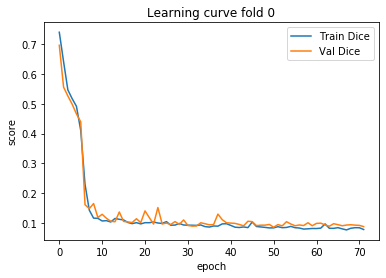

In [16]:
plt.plot(train_folds_loss[0]) 
plt.plot(valid_folds_loss[0])
plt.title('Learning curve fold 0')
plt.ylabel('score')
plt.xlabel('epoch')
plt.legend(['Train Dice', 'Val Dice'], loc='upper right')
plt.show()

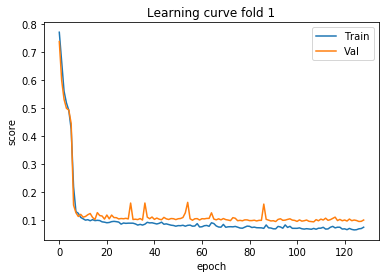

In [17]:
plt.plot(train_folds_loss[1]) 
plt.plot(valid_folds_loss[1])
plt.title('Learning curve fold 1')
plt.ylabel('score')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

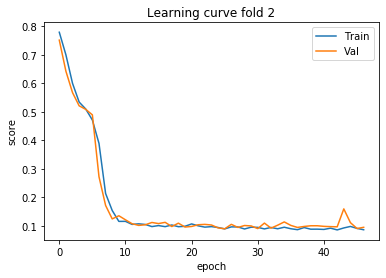

In [18]:
plt.plot(train_folds_loss[2]) 
plt.plot(valid_folds_loss[2])
plt.title('Learning curve fold 2')
plt.ylabel('score')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

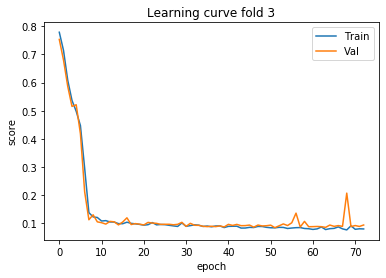

In [19]:
plt.plot(train_folds_loss[3]) 
plt.plot(valid_folds_loss[3])
plt.title('Learning curve fold 3')
plt.ylabel('score')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

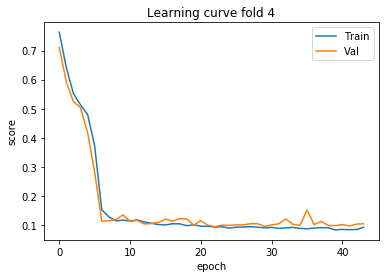

In [20]:
plt.plot(train_folds_loss[4]) 
plt.plot(valid_folds_loss[4])
plt.title('Learning curve fold 4')
plt.ylabel('score')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()